<h1>Global Distribution of Infections and Vaccinations of/to COVID-19</h1>

The following notebook walks through the CRISP-DM in order to satisfy the requirements of project 1 for Udemy's Data Scientist Nanodegree. The notebook exploits the following datasets obtained from Kaggle.

<ol>
  <li><a href="https://www.kaggle.com/gpreda/covid-world-vaccination-progress/metadata">COVID-19 World Vaccination Progress </a> <b>(WVP)</b> - Provides information time-stamped information about when and where (countries) vaccinations are happening, along the brands of the vaccines being utilized at each of the countries.</li>
  <li><a href="https://www.kaggle.com/josephassaker/covid19-global-dataset">COVID-19 Global Dataset</a> <b>(CIC)</b> - Provides time-stamped information about Confirmed Infections with COVID-19 </li>
</ol>

The main goals of the combined analysis of these datasets are to:
<ol>
    <li> Rank a subset of the contries on their vaccination rates. </li>
    <li> Rank a subset of the countries on their daily infection rates. </li>
    <li> Visualize correlations between vaccination rates and infection rates </li>
    <li> Measure the reach of each of the vaccine brands </li>
</ol>



In [1]:
# library imports
import pandas as pd
import sys
import os
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from collections import OrderedDict
from IPython.core.display import display, HTML


In [2]:
# Helpers

# Defining a Class to Make horizontal bar graphs
class BarMaker:
    '''
    Supports generation of pyplot horizontal bar charts
    
    The class supports a special bar chart that can display two bars for the same y tick
    useful on comparing two parameters for a single subject
    '''
    def __init__(self, y_label_list, title, x_step=12, width=0.35):
        '''
        The constructor sets up generic parameters for the visualization
        
        Args:
            y_label_list (list): List of strings that will be used on the ticks of the y axis
            title (str): Graph title
            x_step (int): The number of ticks on the x axis
            width (float): Used for the special case of dual bars for a single ytick.
                           It controls the percent of the total bar width each of the bars will have.
        
        '''
        self.fig, self.ax = plt.subplots()
        self.fig.set_size_inches((6, 4))
        self.ax.xaxis.grid(True, linestyle='--', which='major',
                        color='grey', alpha=.8)
        self.horizontal_grid_steps = x_step
        self.fig.tight_layout()
        self.fig.set_dpi(200)
        self.ax.invert_yaxis()
        self.y_label_list = y_label_list
        self.ypos = np.arange(len(y_label_list))
        self.width = width
        self.ax.set_title(title)

    def set_y(self, bar_values, legend=[None]):
        '''
        Sets values and parameters for the y axis, including the bar graph themselfs
        
        Args:
            bar_values (iterable): Either list of numpy array with values used to generate the total length
                                    of each of the bars
            legend (str): String to be used on the legend for the entire set of bars in bar_values
        
        '''
        if len(bar_values) == 1:
            self.ax.barh(self.ypos , bar_values[0], align='center', label=legend[0])
        else:
            self.ax.barh(self.ypos - self.width/2, bar_values[0], self.width, align='center', label=legend[0])
            self.ax.barh(self.ypos + self.width/2, bar_values[1], self.width, align='center', label=legend[1])            
        self.ax.set_yticks(self.ypos)
        self.ax.set_yticklabels(self.y_label_list)

    def set_x(self, max_x, str_normalizer, label, tick_method='a'):
        '''
        Sets values and parameters for the x axis.
        
        max_x (float): maximum value the x axis ticks will have
        str_normalizer (float): used to normalize or scale the x ticks (to fit within certain precision or range)
        label (str): label for the x axis
        tick_method (char): Possible methods are 'a' or 'b'. Method 'a' presents x ticks labels as a floating point
                            The 'b' method presents the x tick labels in engineering format 
        '''
        xaxis_ticks_num = np.linspace(0, max_x, self.horizontal_grid_steps)
        if tick_method=='b':
            xaxis_ticks_str = [ "{}".format(int(number*str_normalizer)) for number in xaxis_ticks_num]
        else:
            xaxis_ticks_str = [ "{:.1e}".format(number*str_normalizer) for number in xaxis_ticks_num]
        self.ax.set_xticks(xaxis_ticks_num)
        self.ax.set_xticklabels(xaxis_ticks_str, fontsize=6)
        self.ax.set_xlabel(label)
        self.ax.legend()

    def show(self):
        plt.show()
# This will execute as a java script and interact with jupyter notebook at the HTML level to hide python warnings.        
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')        

<h2> Data Understanding, WVP Dataset </h2>

In [3]:
# Reading vaccination data
cwd = './'
vacdat_file_path = os.path.join(cwd,'covid_vaccination_progress', 'country_vaccinations.csv')

vacdat = pd.read_csv(vacdat_file_path)
total_records = vacdat.shape[0]
vacdat.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Albania,ALB,2021-01-10,0.0,0.0,NaN,NaN,NaN,0.00,0.00,NaN,NaN,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...
1,Albania,ALB,2021-01-11,NaN,NaN,NaN,NaN,64.0,NaN,NaN,NaN,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...
2,Albania,ALB,2021-01-12,128.0,128.0,NaN,NaN,64.0,0.00,0.00,NaN,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...
3,Albania,ALB,2021-01-13,188.0,188.0,NaN,60.0,63.0,0.01,0.01,NaN,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...
4,Albania,ALB,2021-01-14,266.0,266.0,NaN,78.0,66.0,0.01,0.01,NaN,23.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...


This dataset provide multiple records for each the reporting countries. Each record for each country represent a data point informing dataset users of updates on the number of additional persons vaccinated that day, further broken down by people that have reached 'full vaccination' (two shots, full immunity). Dividing the total number of vaccinations by the time window on which these vaccinations were performed yields average vaccination rate as Vaccines / Days. This metric will be needed to achieve goal 1, Rank a subset of the contries on their vaccination rates.

However, before drawing metrics and analysis from the dataset, clean up steps are required.



<h3>Data Cleanup, WVP Dataset</h3>

In [4]:
# Removing NaN values of some of the columns of interest
nan_remove = ['total_vaccinations',
            'people_vaccinated',
            'people_fully_vaccinated',
            'daily_vaccinations_raw',
            'daily_vaccinations',
            'people_vaccinated_per_hundred',
            'people_fully_vaccinated_per_hundred',
            'daily_vaccinations_per_million']
for col_name in nan_remove:
    vacdat[col_name].fillna(0, inplace=True)
vacdat['date'] = pd.to_datetime(vacdat['date'])
vacdat.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Albania,ALB,2021-01-10,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...
1,Albania,ALB,2021-01-11,0.0,0.0,0.0,0.0,64.0,NaN,0.00,0.0,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...
2,Albania,ALB,2021-01-12,128.0,128.0,0.0,0.0,64.0,0.00,0.00,0.0,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...
3,Albania,ALB,2021-01-13,188.0,188.0,0.0,60.0,63.0,0.01,0.01,0.0,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...
4,Albania,ALB,2021-01-14,266.0,266.0,0.0,78.0,66.0,0.01,0.01,0.0,23.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...


<h3>Data Exploration and Additional Cleanup, WVP Dataset</h3>

In this section variable-re-mapping happens for vaccine names. This should support improved graphic generation.

One of the first findings about analyzing the data is the number of countries present in the dataset. The labels assigned to each of the vaccines being used can also be obtained. Please note that the naming conventions used include forward slash. 

In [5]:
# Obtaining list of all countries in alphabetical order
countries = list(set(vacdat['country']))
countries.sort()
number_of_countries = len(countries)
to_display = "Number of countries in the dataset: {}".format(number_of_countries)
to_display = '<h5>' + to_display + '</h5>'
display(HTML(to_display))

In [6]:
# What are the tags/labels being used to display all the vaccine brands being used?
print(set(vacdat['vaccines'].values))

{'Moderna, Pfizer/BioNTech', 'Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac', 'Oxford/AstraZeneca, Pfizer/BioNTech', 'Covaxin, Oxford/AstraZeneca', 'Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sinopharm/Wuhan, Sputnik V', 'Pfizer/BioNTech', 'Oxford/AstraZeneca, Sinopharm/Beijing, Sputnik V', 'Sputnik V', 'Pfizer/BioNTech, Sinopharm/Beijing', 'Sinopharm/Beijing', 'Oxford/AstraZeneca, Sinovac', 'Moderna, Oxford/AstraZeneca, Pfizer/BioNTech', 'Pfizer/BioNTech, Sinovac', 'Pfizer/BioNTech, Sinopharm/Beijing, Sputnik V', 'Oxford/AstraZeneca, Sputnik V', 'Oxford/AstraZeneca', 'Oxford/AstraZeneca, Sinopharm/Beijing', 'Sinovac'}


In addition to this, when more than one vaccine brand is being used on a given country, the set of vaccines are represented with a coma separated string. Further analysis and visualization requires finding alternative ways of representing this vaccine brands per country.

In [7]:
# Re-mapping vaccine-identifying strings to a shorter more readable tag in support of Goal 4
vac_tags = ['Oxford',
            'Pfizer',
            'Sinopharm-W',
            'Sinopharm-B',
            'Sinovac',
            'Sputnik V',
            'Moderna',
            'Covaxin']
vac_hash = OrderedDict()
vac_hash['Oxford/AstraZeneca'] = 'Oxford'
vac_hash['Pfizer/BioNTech'] = 'Pfizer'
vac_hash['Sinopharm/Wuhan'] = 'Sinopharm-W'
vac_hash['Sinopharm/Beijing'] = 'Sinopharm-B'
vac_hash['Sinovac'] = 'Sinovac'
vac_hash['Sputnik V'] = 'Sputnik V'
vac_hash['Moderna'] = 'Moderna'
vac_hash['Covaxin'] = 'Covaxin'


In [8]:
# Creating a storage objects for vaccine tags to be filled up in a loop later on
# This will be used to support Goal 4
vac_series = {}
for tag in vac_tags:
    vac_series[tag] = [0]*total_records

In [9]:
# Converting the database's vaccine identifying strings to more readable tags in support to goal 4
new_vac_col = []
row_indx = 0
for record in vacdat['vaccines'].values:
    components = record.replace(', ',',').split(",")
    new_components = []
    for sub_component in components:
        if sub_component in vac_hash.keys():
            new_components.append(vac_hash[sub_component])
            vac_series[vac_hash[sub_component]][row_indx] = 1
        else:
            msg = "Warning. vacccine name {} not found in hash".format(sub_component)
            print(msg)
            break
        new_vac_col.append(new_components)
    row_indx+=1

In [10]:
# Creating a dictionary with empty arrays. It will be used to
# store the countries using a given vaccine brand on a binary format
vac_tag_in_country = {}
for vac_tag in vac_tags:
    vac_tag_in_country[vac_tag] = []

In [11]:
# Generates new boolean columns to determine what vaccines are being used, and
# where. Supports Goal 4
insert_loc = 13
for j, vac_tag in enumerate(vac_tags):
    vacdat.insert(insert_loc + j, vac_tag, vac_series[vac_tag])
vacdat.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,...,Oxford,Pfizer,Sinopharm-W,Sinopharm-B,Sinovac,Sputnik V,Moderna,Covaxin,source_name,source_website
0,Albania,ALB,2021-01-10,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0,1,0,0,0,0,0,0,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...
1,Albania,ALB,2021-01-11,0.0,0.0,0.0,0.0,64.0,NaN,0.00,...,0,1,0,0,0,0,0,0,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...
2,Albania,ALB,2021-01-12,128.0,128.0,0.0,0.0,64.0,0.00,0.00,...,0,1,0,0,0,0,0,0,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...
3,Albania,ALB,2021-01-13,188.0,188.0,0.0,60.0,63.0,0.01,0.01,...,0,1,0,0,0,0,0,0,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...
4,Albania,ALB,2021-01-14,266.0,266.0,0.0,78.0,66.0,0.01,0.01,...,0,1,0,0,0,0,0,0,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...


In [12]:
# Creating a dictionary of  country populations in support to Goal 1 and 2
power_countries = [
    'China',
    'United States',
    'Germany',
    'India',
    'Italy',
    'France',
    'United Kingdom',
    'Brazil',
    'Canada',
    'Russia',
    'Israel']
# Values manually obtained from online sources (wikipedia.org)
power_countries_population = OrderedDict()    
power_countries_population['China'] = 1.398E9
power_countries_population['United States'] = 328.2E6
power_countries_population['Germany'] = 83.02E6
power_countries_population['India'] = 1.366E9
power_countries_population['Italy'] = 60.36E6
power_countries_population['France'] = 67.06E6
power_countries_population['United Kingdom'] = 66.65E6
power_countries_population['Brazil'] = 211.0E6
power_countries_population['Canada'] = 37.59E6
power_countries_population['Russia'] = 144.4E6
power_countries_population['Israel'] = 9.053E6

<h3>Data Analysis, WVP Dataset</h3>

In this section, everything needed to compute vaccination rate is extracted and stored in a new data frame. The loop iterates over all records, providing an opportunity to extract information about what vaccine is being used where.

In [13]:
# This sections generates new analytic data from existing data. The new data will be
# presented and analyzed through graphics and text

total_vaccinations_per_country = OrderedDict()
country_dic = OrderedDict()

country_dic['country'] = []
country_dic['start_date'] = []
country_dic['end_date'] = []
country_dic['avg_vac_speed'] = []
country_dic['total_vacs'] = []
country_dic['reported_days'] = []

country_daily_vacs = {'country': [], 'country_daily_vacs': []}
def delta_days(end_date, start_date):
    time_frame = end_date - start_date
    time_frame = time_frame.astype('timedelta64[D]')
    return time_frame / np.timedelta64(1, 'D')
power_country_indx = []
j = 0    
for country in countries:
    if country in power_countries:
        power_country_indx.append(j)
    # Creating subset for one country
    sub_frame = vacdat[vacdat['country']==country]
    # Obtaining all information needed to compute vaccination rate
    country_dic['country'].append(country)
    country_dic['total_vacs'].append(sub_frame['total_vaccinations'].values[-1])
    country_dic['start_date'].append(sub_frame['date'].values[0])
    country_dic['end_date'].append(sub_frame['date'].values[-1])
    country_dic['reported_days'].append(delta_days(sub_frame['date'].values[-1], sub_frame['date'].values[0]))
    country_dic['avg_vac_speed'].append(country_dic['total_vacs'][-1]/country_dic['reported_days'][-1])
    country_daily_vacs['country'].append(country)
    country_daily_vacs['country_daily_vacs'].append(sub_frame['daily_vaccinations'].values[:])
    # Obtaining information about the countries using a a given vaccine brand
    for vac_tag in vac_tags:
        if any(sub_frame[vac_tag].values):
            vac_tag_in_country[vac_tag].append(country)
    j+=1
country_df = pd.DataFrame(country_dic)
    

<ipython-input-13-b09ae26644dc>:32: RuntimeWarning: divide by zero encountered in double_scalars
  country_dic['avg_vac_speed'].append(country_dic['total_vacs'][-1]/country_dic['reported_days'][-1])


In [14]:
# Displaying information about vaccine brand reach
vac_tag_in_country_df = pd.DataFrame({'vac_tag': vac_tags,
                                     'countries_with_vac': [vac_tag_in_country[vac_tag] for vac_tag in vac_tags],
                                     'vac_reach': [len(vac_tag_in_country[vac_tag]) for vac_tag in vac_tags]})
vac_tag_in_country_df = vac_tag_in_country_df.sort_values(by='vac_reach', ascending=False)
vac_tag_in_country_df = vac_tag_in_country_df.set_index('vac_tag')
print(vac_tag_in_country_df)
print('')
print(vac_tag_in_country_df.vac_reach/number_of_countries*100)

                                            countries_with_vac  vac_reach
vac_tag                                                                  
Pfizer       [Albania, Andorra, Austria, Bahrain, Belgium, ...         65
Oxford       [Anguilla, Austria, Azerbaijan, Bangladesh, Be...         45
Moderna      [Austria, Belgium, Bulgaria, Canada, Czechia, ...         27
Sinopharm-B  [Bahrain, Cambodia, China, Egypt, Morocco, Pak...         10
Sputnik V    [Algeria, Argentina, Azerbaijan, Bolivia, Iran...          9
Sinovac      [Brazil, Chile, China, Indonesia, Northern Cyp...          6
Sinopharm-W                      [China, United Arab Emirates]          2
Covaxin                                                [India]          1

vac_tag
Pfizer         72.222222
Oxford         50.000000
Moderna        30.000000
Sinopharm-B    11.111111
Sputnik V      10.000000
Sinovac         6.666667
Sinopharm-W     2.222222
Covaxin         1.111111
Name: vac_reach, dtype: float64


In [15]:
# Displaying information about vaccine brand reach
for tag in vac_tag_in_country_df.index:
    print("The vaccine '{0}' is being used in {1} countries".format(tag, vac_tag_in_country_df.loc[tag, 'vac_reach']))

The vaccine 'Pfizer' is being used in 65 countries
The vaccine 'Oxford' is being used in 45 countries
The vaccine 'Moderna' is being used in 27 countries
The vaccine 'Sinopharm-B' is being used in 10 countries
The vaccine 'Sputnik V' is being used in 9 countries
The vaccine 'Sinovac' is being used in 6 countries
The vaccine 'Sinopharm-W' is being used in 2 countries
The vaccine 'Covaxin' is being used in 1 countries


This information is achieves goal 4 of assessing the reach 

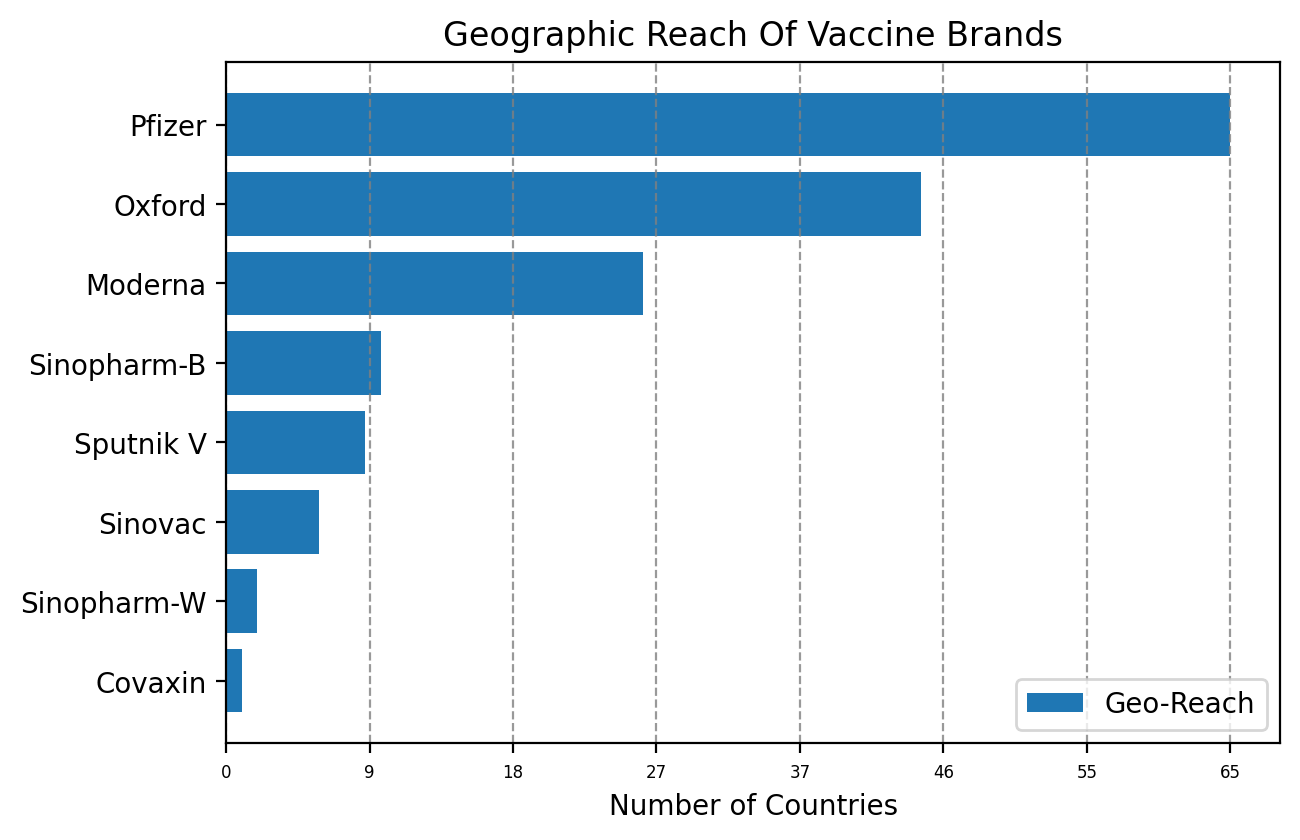

In [16]:
bar_maker = BarMaker(vac_tag_in_country_df.index, 'Geographic Reach Of Vaccine Brands', x_step=8)
bar_maker.set_y([vac_tag_in_country_df['vac_reach'].values], legend=['Geo-Reach'])
bar_maker.set_x(vac_tag_in_country_df['vac_reach'].max(), 1, 'Number of Countries', tick_method='b')
bar_maker.show()

The following section will  focus on a subset of industrialized countries. Focusing on this countries is a workaround for potentially incomplete low reliability data from non-industrialized countries. It also allow users to rank countries with comparable resources on their ability to prevent infections and drive vaccinations. 

In [17]:
# Creating a subset of the dataframe. Includes a limited number of industrialized countries
power_country_df = country_df.iloc[power_country_indx, :]
power_country_df.head(11)

,country,start_date,end_date,avg_vac_speed,total_vacs,reported_days
12,Brazil,2021-01-16,2021-02-15,176465.966667,5293979.0,30.0
15,Canada,2020-12-19,2021-02-15,21695.862069,1258360.0,58.0
18,China,2020-12-15,2021-02-09,723571.428571,40520000.0,56.0
30,France,2020-12-27,2021-02-14,59111.673469,2896472.0,49.0
31,Germany,2020-12-27,2021-02-14,84619.346939,4146348.0,49.0
38,India,2021-01-15,2021-02-15,281316.838710,8720822.0,31.0
43,Israel,2020-12-19,2021-02-15,113789.637931,6599799.0,58.0
44,Italy,2020-12-27,2021-02-15,60890.700000,3044535.0,50.0
71,Russia,2020-12-15,2021-02-10,68421.052632,3900000.0,57.0
87,United Kingdom,2020-12-13,2021-02-14,251425.095238,15839781.0,63.0


With this information and the population information, vaccination rate can be computed.

In [18]:
# Mapping Country DF with metadata about the countries population.
ordered_population = [int(power_countries_population[country]) for country in power_country_df['country'].values]
power_country_df['population'] = ordered_population
# Nomralizing vaccination rate to the countries population
power_country_df['normalized_vac_speed'] = power_country_df['avg_vac_speed']/power_country_df['population']
power_country_df = power_country_df.sort_values(by='avg_vac_speed', ascending=False)
power_country_df.head(11)
SECONDS_IN_DAY = 86400
vacs_second = power_country_df['avg_vac_speed'].max()/SECONDS_IN_DAY

print("Vaccinations Per Second on Top grossing country is: {}".format(vacs_second))

Vaccinations Per Second on Top grossing country is: 10.930133101851851


<ipython-input-18-eb1450b0b809>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_country_df['population'] = ordered_population
<ipython-input-18-eb1450b0b809>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_country_df['normalized_vac_speed'] = power_country_df['avg_vac_speed']/power_country_df['population']


At this point we can visualize the rate at which the subset of industrialized countries are vaccinating their people.

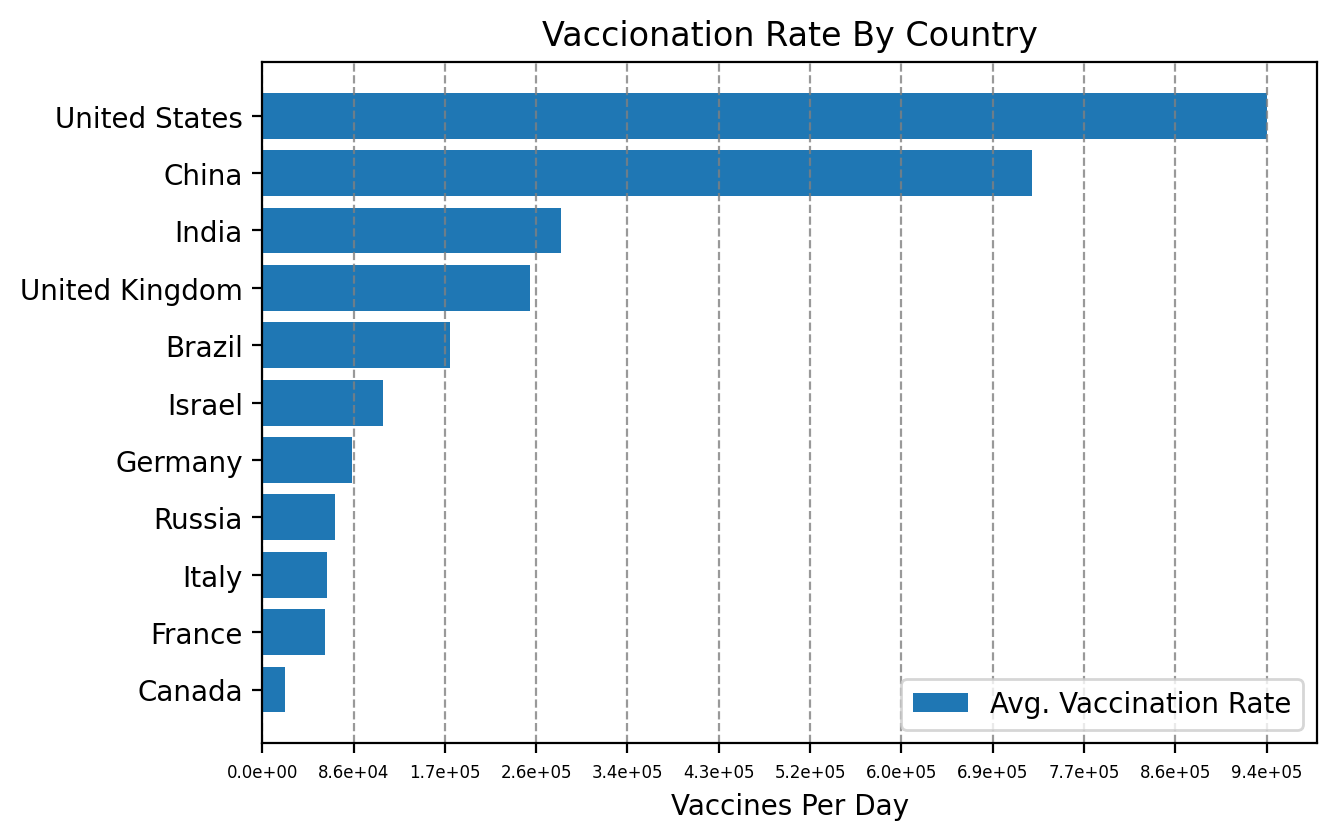

In [19]:
# Vaccines Per Day on Industrialized Countries
power_country_df = power_country_df.sort_values(by='avg_vac_speed', ascending=False)
bar_maker = BarMaker(power_country_df['country'].values, 'Vaccionation Rate By Country')
bar_maker.set_y([power_country_df['avg_vac_speed'].values], legend=['Avg. Vaccination Rate'])
bar_maker.set_x(power_country_df['avg_vac_speed'].max(), 1, 'Vaccines Per Day')
bar_maker.show()

United States tops the list vaccinating at a rate of approximately 0.9 million vaccines per day. However, visualizing this information after normalization by population shows that Israel topping the list by significant margins. 

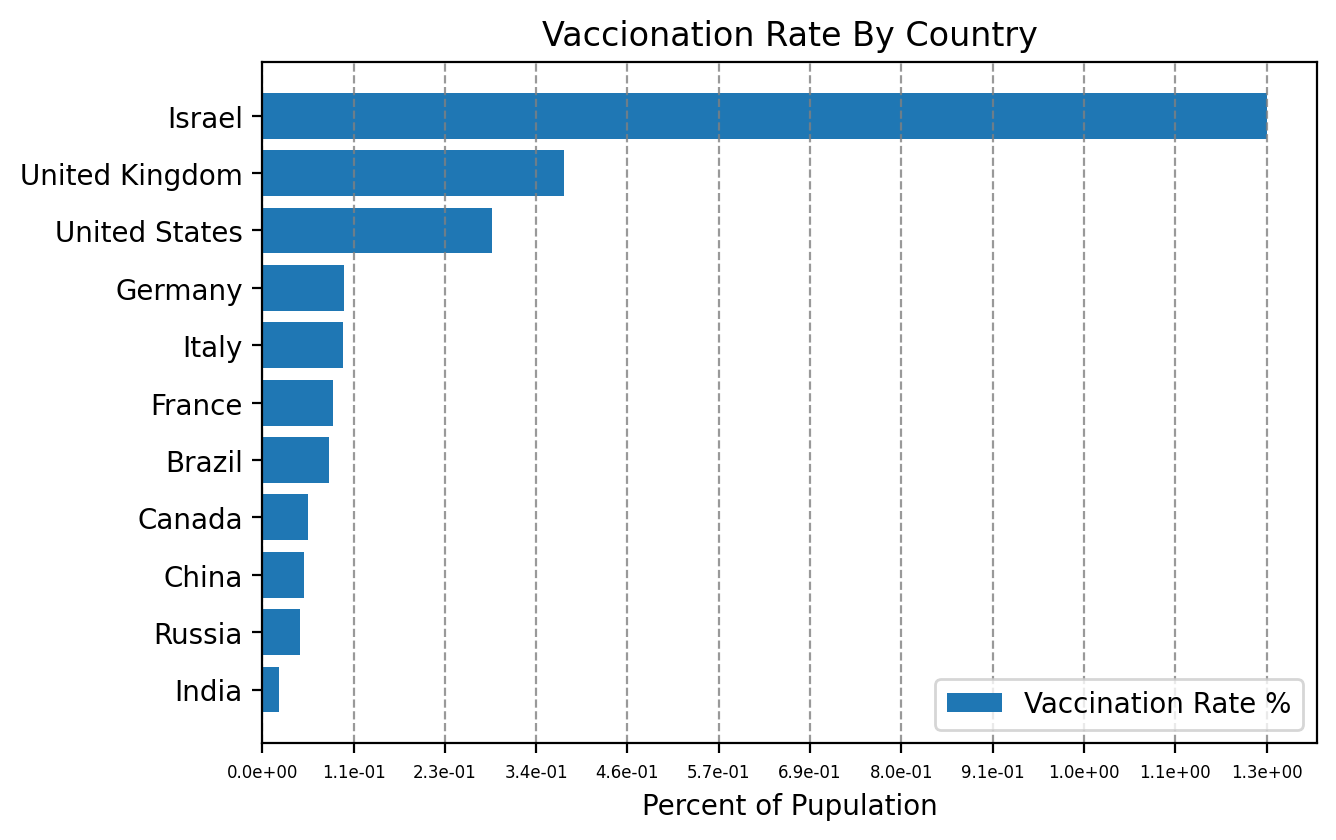

In [20]:
# Vaccines Per Day on Industrialized Countries Normalized by Population
power_country_df = power_country_df.sort_values(by='normalized_vac_speed', ascending=False)
bar_maker = BarMaker(power_country_df['country'].values, 'Vaccionation Rate By Country')
bar_maker.set_y([power_country_df['normalized_vac_speed'].values], legend=['Vaccination Rate %'])
bar_maker.set_x(power_country_df['normalized_vac_speed'].max(), 100, 'Percent of Pupulation')


<h2> Data Understanding, CIC Dataset </h2>

In [21]:
# Reading infections per day data
infdat_file_path = os.path.join(cwd,'covid_daily_confirm','worldometer_coronavirus_daily_data.csv')
infdat = pd.read_csv(infdat_file_path)
inf_total_records = vacdat.shape[0]
infdat.tail(10)

,date,country,cumulative_total_cases,daily_new_cases,active_cases,cumulative_total_deaths,daily_new_deaths
80168,2021-2-05,Zimbabwe,34331.0,160.0,4883.0,1303.0,15.0
80169,2021-2-06,Zimbabwe,34487.0,156.0,4788.0,1316.0,13.0
80170,2021-2-07,Zimbabwe,34552.0,65.0,4675.0,1326.0,10.0
80171,2021-2-08,Zimbabwe,34658.0,106.0,4494.0,1339.0,13.0
80172,2021-2-09,Zimbabwe,34781.0,123.0,4139.0,1353.0,14.0
80173,2021-2-10,Zimbabwe,34864.0,83.0,4029.0,1364.0,11.0
80174,2021-2-11,Zimbabwe,34949.0,85.0,4096.0,1382.0,18.0
80175,2021-2-12,Zimbabwe,35045.0,96.0,3693.0,1393.0,11.0
80176,2021-2-13,Zimbabwe,35104.0,59.0,3617.0,1398.0,5.0
80177,2021-2-14,Zimbabwe,35172.0,68.0,3171.0,1400.0,2.0


In general, this dataset include time-stamped records with information on how COVID-19 is spreading around the world, and how deadly it has been since its beginnings. This dataset will be used to satisfy Goal 2 and 3. To accomplish this,  the total number of new cases over a time period will be computed, and divided by the number of days of the period. The period will be set to start at the earliest date of vaccination or the date of the WVP dataset. This shall provide insight on the effects of vaccination rate with respect to infection rates. This could potentially be very relevant insight, as it may shed light on the effectiveness of the vaccination campaign on battling the pandemic.

To further analyze this dataset and meet the established goals, only one re-mapping or clean-up step was needed was needed:  making country names consistent across CIC and WVP datasets.

In [22]:
# Replacining country tags so they match previous dataset
infdat['country'] = infdat['country'].replace(['UK', 'USA'], ['United Kingdom','United States'])

<h3>Data Analysis, CIC Dataset</h3>

In this section, everything needed to compute infection rate is extracted and stored in a new data frame. The loop iterates over all records, providing an opportunity to extract and reformat certain fields for further analysis. The new dataframe is later appended with population information. This enables computation of normalized metrics.

In [23]:
# This sections generates new analytic data from existing data. The new data will be
# presented and analyzed through graphics and text. This analysis only takes place for the subset
# previously selected datasets. Note that this subset is further contrained by date
infdat['date'] = pd.to_datetime(infdat['date'])
infdat.head()
country_inf_dic =     {'country': [],
    'start_date': [],
    'end_date': [],
    'avg_inf_speed': [],
    'total_inf': [],
    'reported_days': [],
    }
country_daily_inf = {
    'country': [],
    'daily_new_cases': [],
    'active_cases': []}    
power_country_indx = []
j = 0
countries = list(set(infdat['country'].values))
countries.sort()

for country in countries:
    if country in power_countries:
        power_country_indx.append(j)
        sub_frame = infdat[infdat['country']==country]
        sub_frame = sub_frame[sub_frame['date'] > power_country_df['start_date'].min()]
        country_inf_dic['country'].append(country)
        country_inf_dic['total_inf'].append(np.sum(sub_frame['daily_new_cases'].values[:]))
        country_inf_dic['start_date'].append(sub_frame['date'].values[0])
        country_inf_dic['end_date'].append(sub_frame['date'].values[-1])
        country_inf_dic['reported_days'].append(delta_days(sub_frame['date'].values[-1], sub_frame['date'].values[0]))
        country_inf_dic['avg_inf_speed'].append(country_inf_dic['total_inf'][-1]/country_inf_dic['reported_days'][-1])
        country_daily_inf['country'].append(country)
        country_daily_inf['daily_new_cases'].append(sub_frame['daily_new_cases'].values[:])
        country_daily_inf['active_cases'].append(sub_frame['active_cases'].values[:])
        j+=1

In [24]:
# Adding population data to the dataframe
country_inf_df = pd.DataFrame(country_inf_dic)
ordered_population = [int(power_countries_population[country]) for country in country_inf_df['country'].values]
country_inf_df['population'] = ordered_population
country_inf_df.head(11)

,country,start_date,end_date,avg_inf_speed,total_inf,reported_days,population
0,Brazil,2020-12-14,2021-02-14,47298.758065,2932523.0,62.0,211000000
1,Canada,2020-12-14,2021-02-14,5887.774194,365042.0,62.0,37590000
2,China,2020-12-14,2021-02-14,49.000000,3038.0,62.0,1398000000
3,France,2020-12-14,2021-02-14,17553.403226,1088311.0,62.0,67060000
4,Germany,2020-12-14,2021-02-14,16180.935484,1003218.0,62.0,83020000
5,India,2020-12-14,2021-02-14,16636.387097,1031456.0,62.0,1366000000
6,Israel,2020-12-14,2021-02-14,5922.645161,367204.0,62.0,9053000
7,Italy,2020-12-14,2021-02-14,14205.064516,880714.0,62.0,60360000
8,Russia,2020-12-14,2021-02-14,22870.241935,1417955.0,62.0,144400000
9,United Kingdom,2020-12-14,2021-02-14,35301.209677,2188675.0,62.0,66650000


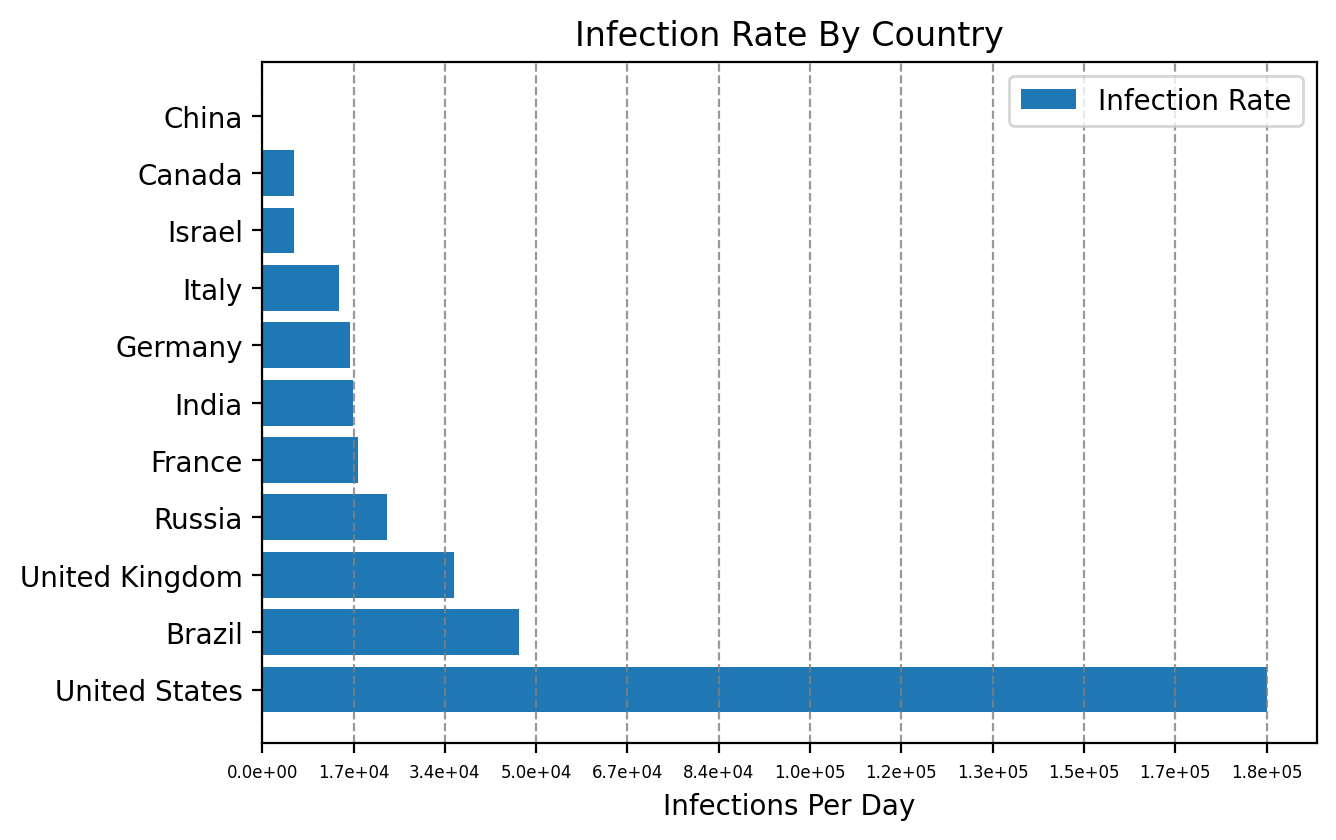

In [25]:
# plotting graph of normalized infection speed normalized by population
country_inf_df = country_inf_df.sort_values(by='avg_inf_speed', ascending=True)
bar_maker = BarMaker(country_inf_df['country'].values, 'Infection Rate By Country')
bar_maker.set_y([country_inf_df['avg_inf_speed'].values], legend=['Infection Rate'])
bar_maker.set_x(country_inf_df['avg_inf_speed'].max(), 1, 'Infections Per Day')
bar_maker.show()

The graphic demonstrate just how much worse total infection rates are on the United States compared to other industrialized nations. Please note that China's apparent ranking could be due to the way the nation is collecting the data.

In [26]:
# Adding infection rate normalized by population
country_inf_df['normalized_inf_speed'] = country_inf_df['avg_inf_speed']/country_inf_df['population']
country_inf_df.describe()

,avg_inf_speed,total_inf,reported_days,population,normalized_inf_speed
count,11.000000,1.100000e+01,11.0,1.100000e+01,1.100000e+01
mean,33349.253666,2.067654e+06,62.0,3.428485e+08,2.718861e-04
std,52050.169216,3.227110e+06,0.0,5.216725e+08,2.179017e-04
min,49.000000,3.038000e+03,62.0,9.053000e+06,3.505007e-08
25%,10063.854839,6.239590e+05,62.0,6.350500e+07,1.575063e-04
50%,16636.387097,1.031456e+06,62.0,8.302000e+07,2.241647e-04
75%,29085.725806,1.803315e+06,62.0,2.696000e+08,3.957036e-04
max,184936.370968,1.146606e+07,62.0,1.398000e+09,6.542191e-04


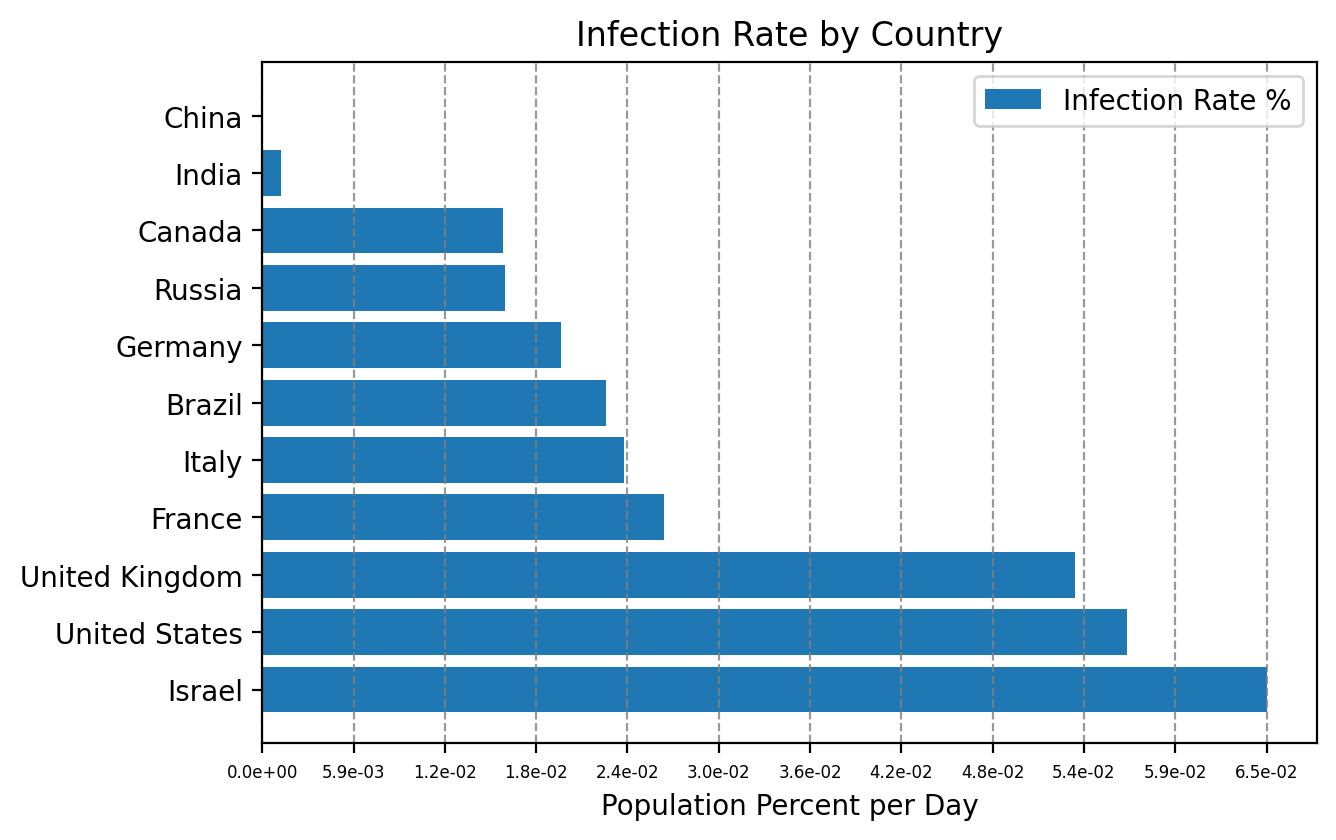

In [27]:
# plotting graph of normalized infection speed normalized by population
country_inf_df = country_inf_df.sort_values(by='normalized_inf_speed', ascending=True)
bar_maker = BarMaker(country_inf_df['country'].values, 'Infection Rate by Country')
bar_maker.set_y([country_inf_df['normalized_inf_speed'].values], legend=['Infection Rate %'])
bar_maker.set_x(country_inf_df['normalized_inf_speed'].max(), 100, 'Population Percent per Day')
bar_maker.show()

After normalizing dataset by population, a more even distribution of infection rates is observed. In this graph, Israel clearly ranks as the country with higher infection rates per capita.

<h2> Combined analysis of WVP and CIC datasets </h2>

The following analysis intends to provide insight as to the correlation between infection rates and vaccination rates. To accomplish this, a new dataframe combining normalized infection rates and vaccination rates per country is created. The hypothesis would be that a higher vaccination rate should correlate with a lower infection rate. A country that ranks high on vaccination rate should should rank high, with the least average infections per day.

In [28]:
# Creating a dataset that combines countries, normalized infection
# rate and normalized vaccination speed
country_inf_df = country_inf_df.sort_values(by='country', ascending=False)
power_country_df = power_country_df.sort_values(by='country', ascending=False)

vacs_inf = OrderedDict()
vacs_inf['country'] = []
vacs_inf['normalized_inf_speed'] = []
vacs_inf['normalized_vac_speed'] = []
for country in power_country_df['country'].values:
    vacs_inf['country'].append(country)
    nis = country_inf_df.loc[country_inf_df['country']==country, 'normalized_inf_speed']
    vacs_inf['normalized_inf_speed'].append(nis.values[0])
    nvs = power_country_df.loc[power_country_df['country']==country, 'normalized_vac_speed']
    vacs_inf['normalized_vac_speed'].append(nvs.values[0])
vacs_inf_df = pd.DataFrame(vacs_inf)

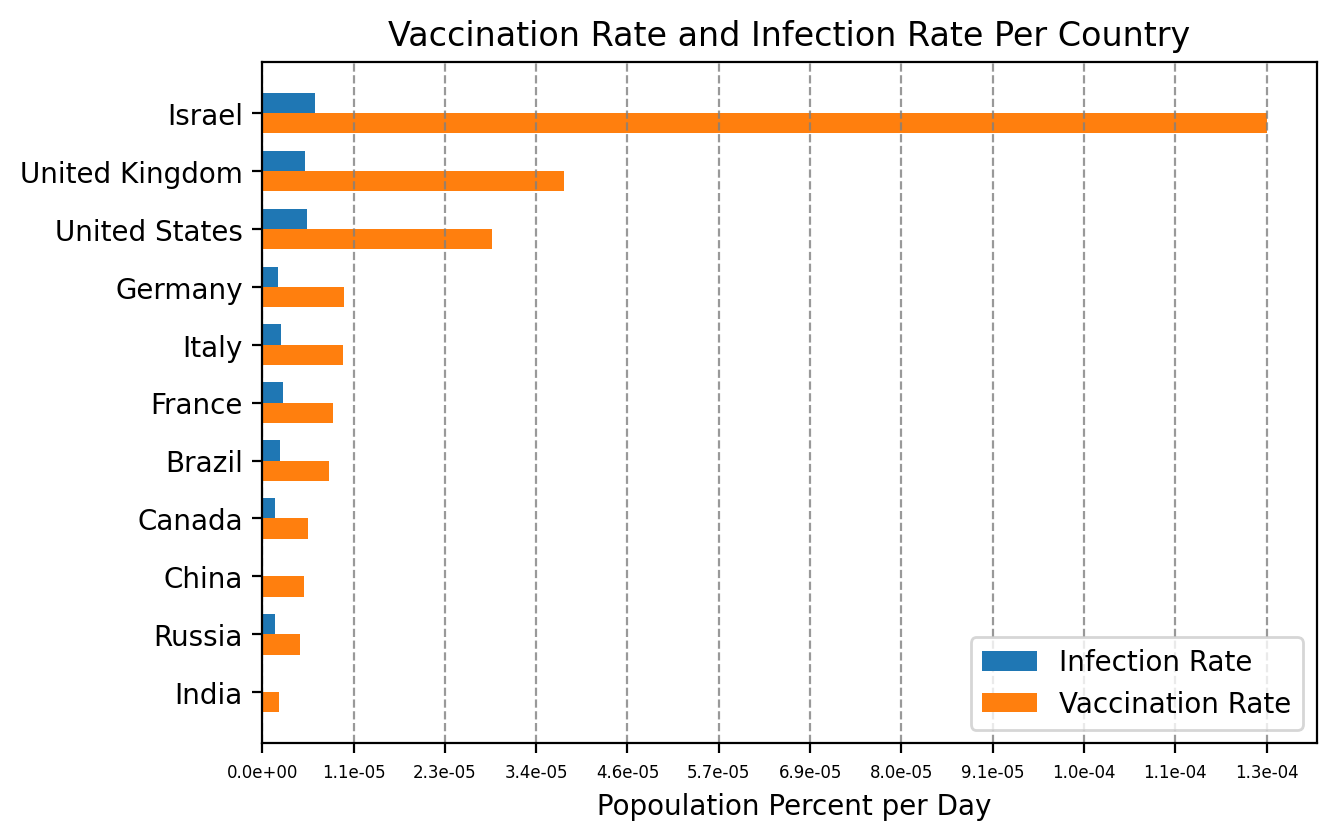

In [29]:
# Plotting infection rate and vaccination rate against the same axis
vacs_inf_df = vacs_inf_df.sort_values(by='normalized_vac_speed', ascending=False)
max_tick = vacs_inf_df['normalized_inf_speed'].max()
if vacs_inf_df['normalized_vac_speed'].max() > max_tick:
    max_tick = vacs_inf_df['normalized_vac_speed'].max()

bars = [vacs_inf_df['normalized_inf_speed'].values, vacs_inf_df['normalized_vac_speed'].values]
legends = ['Infection Rate', 'Vaccination Rate']
    
bar_maker = BarMaker(vacs_inf_df['country'].values, 'Vaccination Rate and Infection Rate Per Country')
bar_maker.set_y(bars, legend=legends)
bar_maker.set_x(max_tick, 1/100, ' Popoulation Percent per Day')
bar_maker.show()

The graph demonstrates that despite of Israel's vaccination ranking on the top, their infection rates are also one of the highest. From this analysis we can further conclude that the most effective campaign against the pandemic could be attributed to Germany. Germany ranks within top best 5 on infection rates, and ranks top 4 on vaccination rates.

The following graph makes an effort to rank combined graphs along a diagonal axis. For this plot, outliers China and India (with infection rates too small to show) had to be removed. The x axis, representing infection rate, has been inverted such as the closest a given country is to the upper right of the plot, the better the country is performing on both fronts of the battle against the pandemic. The y axis has been stretch to a symlog scale. This gives more importance to the vaccination rate and helps create more separation between countries with similar vaccination rates. This manipulations may throw away the numerical significance of certain data points, however, the goal of the plot is to rank the countries, and not to measure how much better one is over the other.

The plots further demonstrate that Germany is  one of the top contenders due to their effective infection prevention and vaccination rates.

In [30]:
# Removing outlier contries
_vacs_inf_df = vacs_inf_df[(vacs_inf_df['country']!='China') & (vacs_inf_df['country']!='India')]

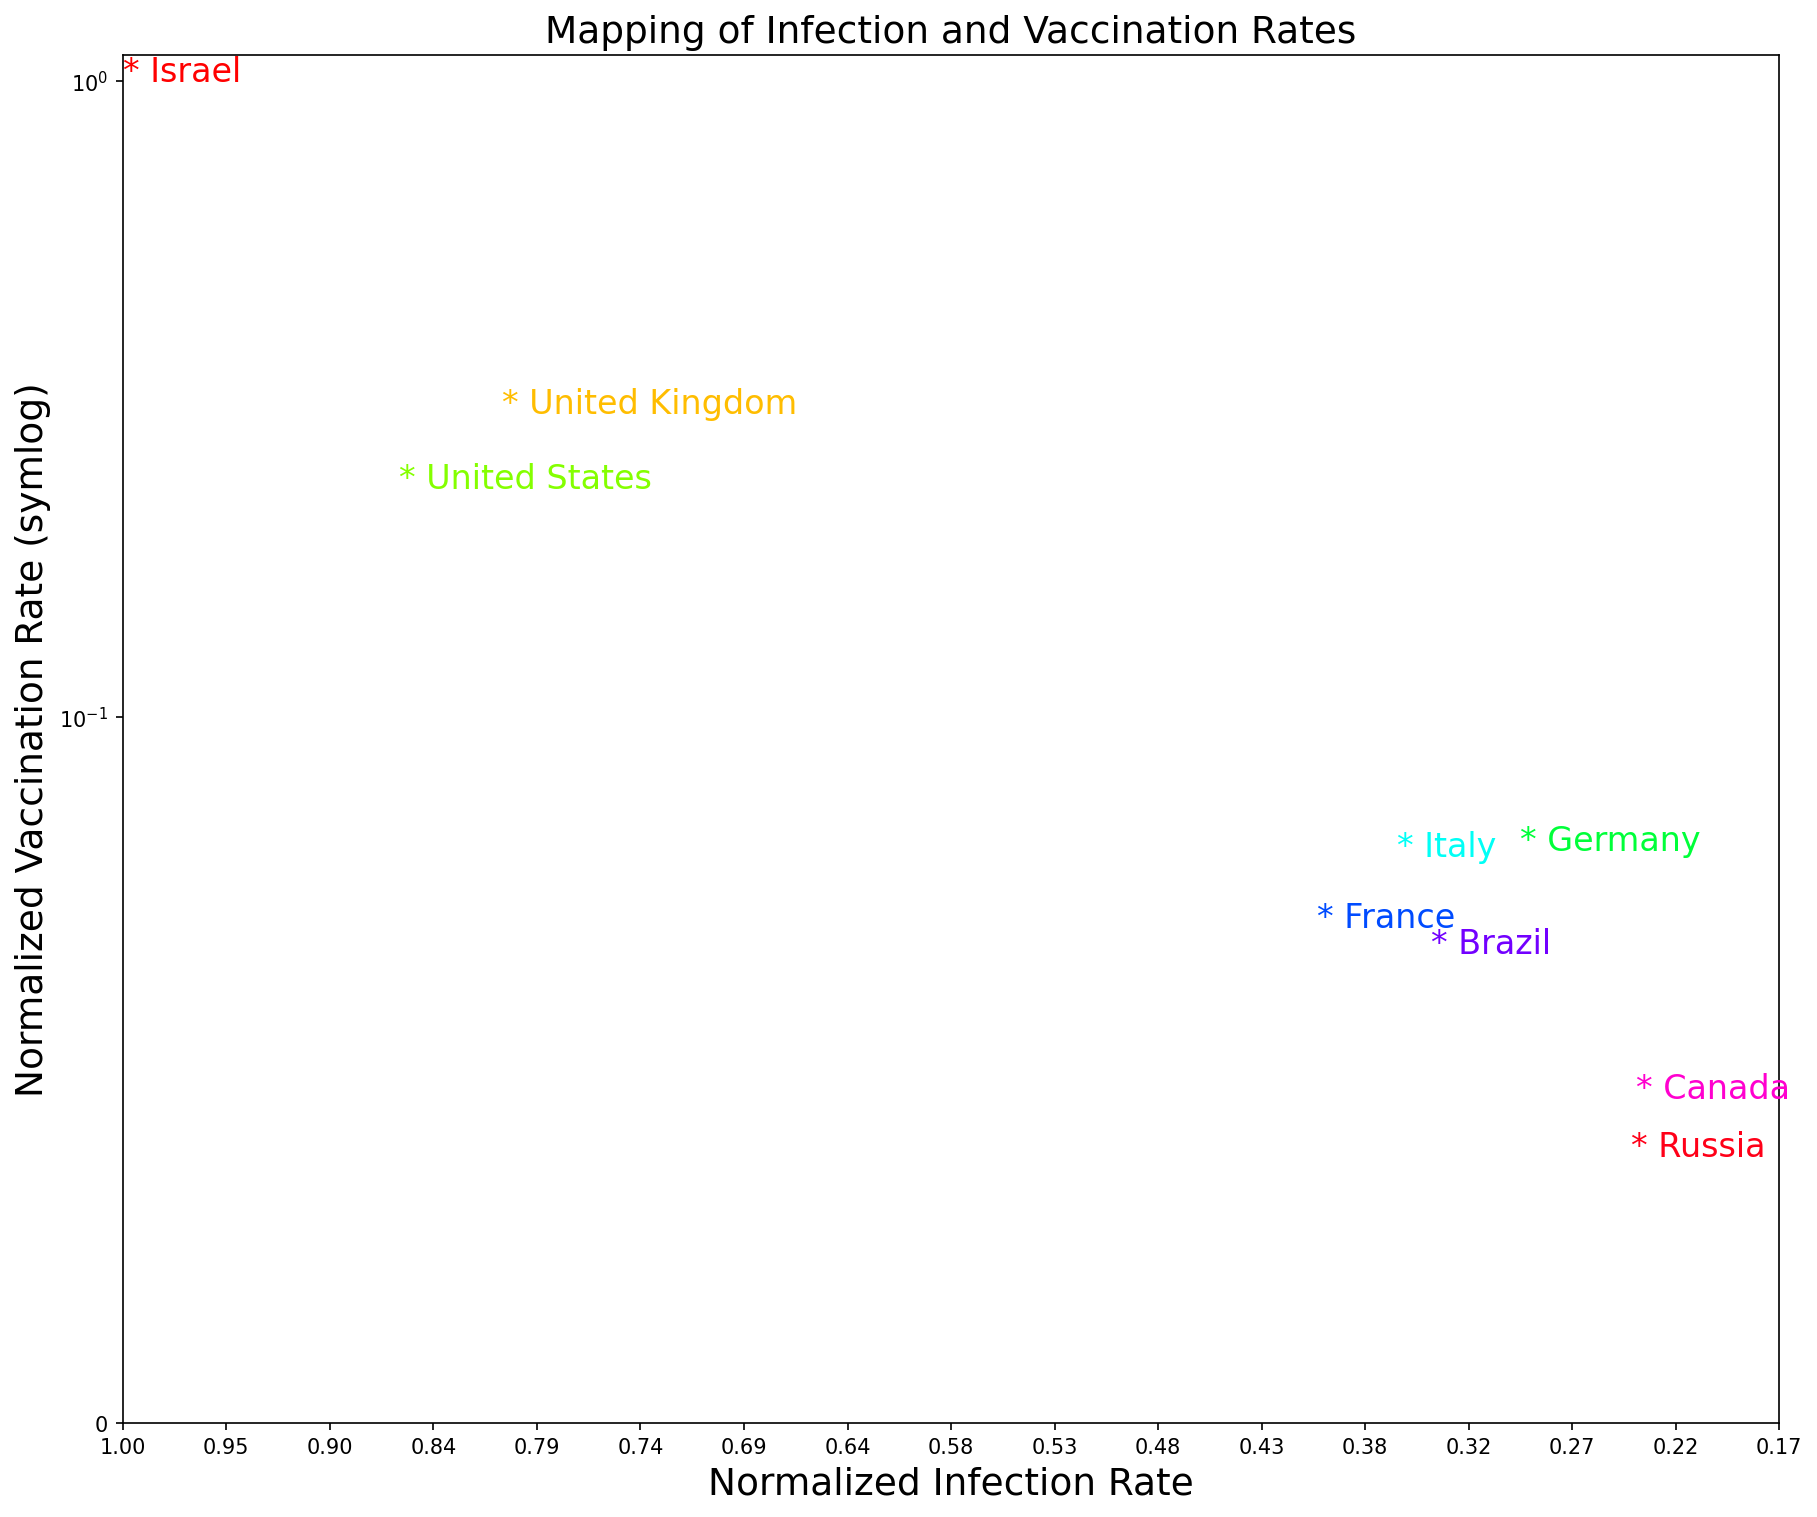

In [33]:
x =  _vacs_inf_df['normalized_inf_speed'].values
# Normalizing everything to be between 0 and 1
x = x/np.max(x) 
y = _vacs_inf_df['normalized_vac_speed'].values
y = y/np.max(y)

#  Cushioning for the plot axis
yextra = 0.1*np.max(y)
xextra = 0.3*np.min(x)

fig, ax = plt.subplots(constrained_layout=True)
fig.set_size_inches((12, 10))
fig.set_dpi(150)

ypos = np.linspace(np.min(y), np.max(y) + yextra, len(y)+8)
ylabels = [ "{:.2f}".format(number) for number in ypos]
ax.set_yticks(ypos)
ax.set_yticklabels(ylabels)

xpos = np.linspace(np.max(x), np.min(x) - xextra, len(x)+8)
xlabels = [ "{:.2f}".format(number) for number in xpos]
ax.set_xticks(xpos)
ax.set_xticklabels(xlabels)

colors = cm.hsv(np.linspace(0, 1, len(_vacs_inf_df['country'].values)))

for i, txt in enumerate(_vacs_inf_df['country'].values):
    ax.annotate('* '+ txt, (x[i], y[i]), fontsize=16, color=colors[i])
ax.invert_xaxis()
ax.set_ylabel('Normalized Vaccination Rate (symlog)', fontsize=18)
ax.set_xlabel('Normalized Infection Rate', fontsize=18)
ax.set_title('Mapping of Infection and Vaccination Rates', fontsize=18)
plt.xlim(xpos[0], xpos[-1]);
plt.yscale('symlog', linthresh=0.1)
# plt.grid(True)